## Clusterización de noticias usando word2vec + kmeans

__word2vec__ son un conjunto de modelos basados en redes neuronales desarrollados por Google.
Este modelo toma como entrada un gran corpus de text como tweets o artículos de noticias y genera un espacio vectorial de varios cientos de dimensiones, a cada palabra en el corpus se le asigna un vector único en el espacio vectorial.
Lo genial de word2vec es que los vectores de las palabras que están cerca uno del otro en el espacio vectorial representan palabras que no solo tienen el mismo significado sino también el mismo contexto.

In [1]:
from gensim.models import word2vec
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import nltk.data # libreria de lenguaje natural
nltk.download('punkt') #descarga token para fomar frases y lista de palabras
nltk.download("stopwords") # descarga stopwords
from nltk.corpus import stopwords

import re
tokenizer = nltk.data.load('nltk:tokenizers/punkt/spanish.pickle')
list_stopwords = stopwords.words('spanish')



[nltk_data] Downloading package punkt to /Users/aalvarez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aalvarez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#oracion a lista de palabras
def sentence_to_wordlist(sentence, remove_stopwords=False):
     # 1. Elimina las no letras
    sentence_text = re.sub(r'[^\w\s]','', sentence)
    # 2. convierte las palabras a minusculas y luego las splitea
    words = sentence_text.lower().split()
    # 3. limpia las stop words en español que podria contener el listado de palabras
    words = [remove_accents(w) for w in words if w.lower() not in list_stopwords]
    return(words)
#texto a oraciones
def oped_to_sentences(oped, tokenizer, remove_stopwords=False ):
    try:
        # 1. Usa el token NLTK para dividir a oraciones
        raw_sentences = tokenizer.tokenize(oped.strip())
        # 2. Recorre cada oracion
        sentences = []
        for raw_sentence in raw_sentences:
            # Si una oracion esta vacia la omito
            if len(raw_sentence) > 0:
                # de otra forma obtengo la lista de palabras
                word_list = sentence_to_wordlist(raw_sentence)
                sentences.append(word_list)
        return sentences
    except:
        print('nope')

import unicodedata
#elimina acentos
def remove_accents(s):
    s = s.encode('utf-8')
    return ''.join((c for c in unicodedata.normalize('NFD', s.decode('utf-8')) if unicodedata.category(c) != 'Mn'))

In [3]:
#  1. Defino un array de archivos, los cuales han sido obtenidos por tecnicas de webscrapping:
#  https://github.com/alexislunatic/Web-Scraping
df_tipos = pd.DataFrame({'tipo':[ "cine", "deporte-total","gastronomia", "politica","tecnologia"]})
#df_tipos = pd.DataFrame({'tipo':[ "politica"]})

sentences = []
arr_vec_prom = []
arr_vec_prom2 = []
arr_vec_palabras = []


#  2. Recorremos el dataframe y abrimos el archivo 
for index, row in df_tipos.iterrows():
    with open(row["tipo"] + ".txt", encoding="utf8") as tipo:
        # 3. leemos el contenido
        data = tipo.read().replace('\n', '')
        # 4. en el webscrapping se añadio un indetificador para dividir las noticias, se hace el split 
        noticias = data.split('212719123')
        i=0
        # 5. se recorre cada noticiaas
        for noticia in noticias:
            # 6. se obtienen las palabras y se añaden a una lista de palabras
            odep = oped_to_sentences(noticia, tokenizer)
            if len(odep or ()) > 0 :
                  sentences += odep

print("Hay  " + str(len(sentences)) + " palabras.")

num_features = 200    # dimensiones de las palabras a crear, recomendado entre 100-200                      
min_word_count = 4   # minimo de palabras a contar                        
num_workers = 4       # numeros de hilos para correr en paralelo el modelo
context = 6           # numero de palabras que afectan a otras en un contexto                                                                                  
downsampling = 1e-3   # Muestreo hacia abajo para palabras frequentes

modelo = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

vectores = []
arr_words = []

#7. guardamos  vectores y palabras 
for i in modelo.wv.vocab:
        vectores.append(modelo[i])
        arr_words.append(i)
        

Hay  2693 palabras.


In [4]:
# importo libreria
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

# defino el grafico
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="A map of 10000 word vectors",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

# getting a list of word vectors. limit to 10000. each is of 200 dimensions
word_vectors = vectores 

# reduccion de dimensionalidad a  2d vectors
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vectors)

# creo un dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = arr_words 

# pinto el grafico, la palabra aparece cuando paso el mouse.
plot_tfidf.scatter(x='x', y='y', source=tsne_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"palabra": "@words"}
show(plot_tfidf)

Loading BokehJS ...

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2966 samples in 0.019s...
[t-SNE] Computed neighbors for 2966 samples in 1.988s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2966
[t-SNE] Computed conditional probabilities for sample 2000 / 2966
[t-SNE] Computed conditional probabilities for sample 2966 / 2966
[t-SNE] Mean sigma: 0.005054
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.433655
[t-SNE] Error after 1000 iterations: 2.350788


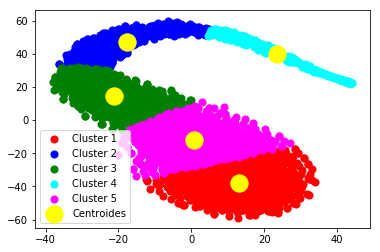

In [5]:

#clusterizamos los vectores

from sklearn.cluster import KMeans
est = KMeans(5)  # K clusters
est.fit(tsne_w2v)
y_kmeans = est.predict(tsne_w2v)

#vectores
#est.cluster_centers_

#mean_data = np.array(vectores)
#mean_data
X=tsne_w2v

plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 50, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 50, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 50, c = 'green', label = 'Cluster 3')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 50, c = 'cyan', label = 'Cluster 4')
plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 50, c = 'magenta', label = 'Cluster 5')
plt.scatter(est.cluster_centers_[:, 0], est.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroides')
plt.legend()

In [6]:
y_kmeans

array([0, 4, 2, ..., 0, 2, 4], dtype=int32)

Hay  7 palabras.


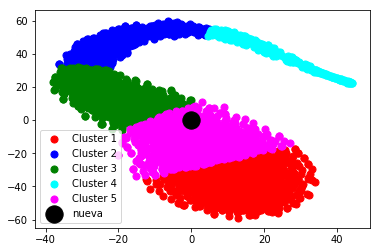

In [7]:
#Nueva noticia
sentences = []

with open("nueva.txt", encoding="utf8") as noticia:
        # 3. leemos el contenido
        data = noticia.read().replace('\n', '')
        odep = oped_to_sentences(data, tokenizer)
        if len(odep or ()) > 0 :
            sentences += odep
                    

print("Hay  " + str(len(sentences)) + " palabras.")

num_features = 2    # dimensiones de las palabras a crear, recomendado entre 100-200                      
min_word_count = 4   # minimo de palabras a contar                        
num_workers = 4       # numeros de hilos para correr en paralelo el modelo
context = 6           # numero de palabras que afectan a otras en un contexto                                                                                  
downsampling = 1e-3   # Muestreo hacia abajo para palabras frequentes
sentences
modelonuevo = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

vectores = []

#7. obtenemos el vector promedio de la nueva noticia
vectores = []
suma = 0
n=1
for i in modelonuevo.wv.vocab:
    suma = suma + modelonuevo[i]
    n= n + 1
vector_promedio = (suma/n)
     
vector_promedio = vector_promedio.reshape(-1,2)
#vector_promedio = vector_promedio.reshape(-1,1)
y_kmeans_new = est.predict(vector_promedio  ) 

y_kmeans_new


plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 50, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 50, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 50, c = 'green', label = 'Cluster 3')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 50, c = 'cyan', label = 'Cluster 4')
plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 50, c = 'magenta', label = 'Cluster 5')

plt.scatter(vector_promedio[:,0] , vector_promedio[:,1], s = 300, c = 'black', label = 'nueva')




plt.legend()
